In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/glass')
mask_dir = os.path.join(dataset_dir,'mask/glass')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/glass C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/glass
13135
13135


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\check_version.py:51: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


[2025-02-15 17:40:29,401: INFO: 3804955329: date_time: 20250215-174029]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "linknet",
    "backbone" : "vgg19", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-15 17:40:29,523: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-15 17:40:29,524: INFO: 342151172: model_config: {'model_name': 'linknet', 'backbone': 'vgg19', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-15 17:40:29,524: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-15 17:40:29,526: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

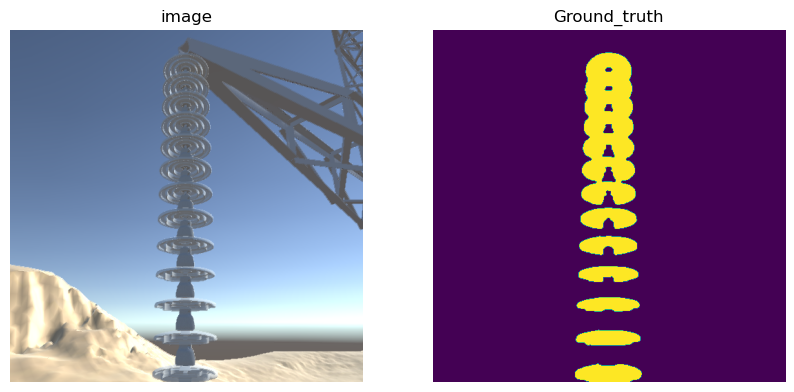

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-15 17:40:29,845: INFO: 3993860970: data injection started]
[2025-02-15 17:40:29,846: INFO: 3993860970: train data spliting ]
[2025-02-15 17:40:29,847: INFO: 3993860970: val test spliting ]
[2025-02-15 17:40:29,848: INFO: 3993860970: csv saving started]
[2025-02-15 17:40:29,863: INFO: 3993860970: train csv done ]
[2025-02-15 17:40:29,866: INFO: 3993860970: val csv done ]
[2025-02-15 17:40:29,869: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\User/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [08:17<00:00, 1.16MB/s] 


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 1752/1752 [06:52<00:00,  4.25it/s, epoch=0, train_loss=0.0237, train_Miou_score=0.544, train_dice_score=0.641, train_acc=0.991, train_binary_jaccard_index=0.88, train_dice_coefficient=0.932] 

[2025-02-15 17:56:32,827: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.023736914883465528]
[2025-02-15 17:56:32,828: INFO: 2273413975: train_loss 0.06874457516100729]
[2025-02-15 17:56:32,828: INFO: 2273413975: train_Miou_score 0.5435906388971223]
[2025-02-15 17:56:32,828: INFO: 2273413975: train_dice_score 0.6414375330733995]
[2025-02-15 17:56:32,829: INFO: 2273413975: train_acc 0.9907919241957468]
[2025-02-15 17:56:32,829: INFO: 2273413975: train_binary_jaccard_index: 0.880425618799854]
[2025-02-15 17:56:32,829: INFO: 2273413975: train_dice_coefficient: 0.9317245288973569]



100%|██████████| 657/657 [00:27<00:00, 23.80it/s, epoch=0, eval_loss=0.00383, eval_Miou_score=0.579, eval_dice_score=0.742, eval_acc=0.997, eval_binary_jaccard_index=0.938, eval_dice_coefficient=0.968]

[2025-02-15 17:57:00,440: INFO: 2273413975: Epoch: 0 | Loss: 0.0038308327056501552]
[2025-02-15 17:57:00,441: INFO: 2273413975: eval_loss 0.003839316078168715]
[2025-02-15 17:57:00,441: INFO: 2273413975: eval_Miou_score 0.5787848169763702]
[2025-02-15 17:57:00,441: INFO: 2273413975: eval_dice_score 0.7422660620517383]
[2025-02-15 17:57:00,442: INFO: 2273413975: eval_acc 0.996541193086807]
[2025-02-15 17:57:00,442: INFO: 2273413975: eval_binary_jaccard_index: 0.9380346109333648]
[2025-02-15 17:57:00,442: INFO: 2273413975: eval_dice_coefficient: 0.9676660785215339]



100%|██████████| 1752/1752 [06:51<00:00,  4.25it/s, epoch=1, train_loss=0.005, train_Miou_score=0.555, train_dice_score=0.676, train_acc=0.993, train_binary_jaccard_index=0.901, train_dice_coefficient=0.945]  

[2025-02-15 18:03:52,270: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.004998135818466204]
[2025-02-15 18:03:52,271: INFO: 2273413975: train_loss 0.03701613625255478]
[2025-02-15 18:03:52,271: INFO: 2273413975: train_Miou_score 0.5547275735813801]
[2025-02-15 18:03:52,271: INFO: 2273413975: train_dice_score 0.675758214678071]
[2025-02-15 18:03:52,271: INFO: 2273413975: train_acc 0.9929870127713027]
[2025-02-15 18:03:52,272: INFO: 2273413975: train_binary_jaccard_index: 0.901351457448957]
[2025-02-15 18:03:52,272: INFO: 2273413975: train_dice_coefficient: 0.9451352703739992]



100%|██████████| 657/657 [00:27<00:00, 23.51it/s, epoch=1, eval_loss=0.00386, eval_Miou_score=0.576, eval_dice_score=0.751, eval_acc=0.996, eval_binary_jaccard_index=0.934, eval_dice_coefficient=0.965]

[2025-02-15 18:04:20,226: INFO: 2273413975: Epoch: 1 | Loss: 0.0038623111251645257]
[2025-02-15 18:04:20,227: INFO: 2273413975: eval_loss 0.003799548204654128]
[2025-02-15 18:04:20,227: INFO: 2273413975: eval_Miou_score 0.5757671117419703]
[2025-02-15 18:04:20,227: INFO: 2273413975: eval_dice_score 0.7513191474082808]
[2025-02-15 18:04:20,228: INFO: 2273413975: eval_acc 0.9963910597825885]
[2025-02-15 18:04:20,228: INFO: 2273413975: eval_binary_jaccard_index: 0.9341342246423573]
[2025-02-15 18:04:20,229: INFO: 2273413975: eval_dice_coefficient: 0.9653306716240031]



100%|██████████| 1752/1752 [06:51<00:00,  4.25it/s, epoch=2, train_loss=0.00334, train_Miou_score=0.563, train_dice_score=0.7, train_acc=0.994, train_binary_jaccard_index=0.916, train_dice_coefficient=0.954]  

[2025-02-15 18:11:12,174: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.0033408983453223694]
[2025-02-15 18:11:12,174: INFO: 2273413975: train_loss 0.025850319007715717]
[2025-02-15 18:11:12,174: INFO: 2273413975: train_Miou_score 0.5633920562372768]
[2025-02-15 18:11:12,175: INFO: 2273413975: train_dice_score 0.7000349349607367]
[2025-02-15 18:11:12,175: INFO: 2273413975: train_acc 0.99422706791754]
[2025-02-15 18:11:12,175: INFO: 2273413975: train_binary_jaccard_index: 0.9155979476035594]
[2025-02-15 18:11:12,176: INFO: 2273413975: train_dice_coefficient: 0.953787809004771]



100%|██████████| 657/657 [00:27<00:00, 24.09it/s, epoch=2, eval_loss=0.00421, eval_Miou_score=0.575, eval_dice_score=0.757, eval_acc=0.996, eval_binary_jaccard_index=0.934, eval_dice_coefficient=0.965]

[2025-02-15 18:11:39,450: INFO: 2273413975: Epoch: 2 | Loss: 0.004212365756477577]
[2025-02-15 18:11:39,450: INFO: 2273413975: eval_loss 0.003980036169789969]
[2025-02-15 18:11:39,451: INFO: 2273413975: eval_Miou_score 0.5750851554579689]
[2025-02-15 18:11:39,451: INFO: 2273413975: eval_dice_score 0.7568427786374685]
[2025-02-15 18:11:39,451: INFO: 2273413975: eval_acc 0.9962000321882258]
[2025-02-15 18:11:39,452: INFO: 2273413975: eval_binary_jaccard_index: 0.9337338986643554]
[2025-02-15 18:11:39,452: INFO: 2273413975: eval_dice_coefficient: 0.9648827250973449]



100%|██████████| 1752/1752 [06:51<00:00,  4.26it/s, epoch=3, train_loss=0.00342, train_Miou_score=0.567, train_dice_score=0.712, train_acc=0.995, train_binary_jaccard_index=0.922, train_dice_coefficient=0.958]

[2025-02-15 18:18:31,072: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.0034203404501148556]
[2025-02-15 18:18:31,072: INFO: 2273413975: train_loss 0.020252713317408393]
[2025-02-15 18:18:31,072: INFO: 2273413975: train_Miou_score 0.5674388769006178]
[2025-02-15 18:18:31,073: INFO: 2273413975: train_dice_score 0.7123435534479429]
[2025-02-15 18:18:31,073: INFO: 2273413975: train_acc 0.9948206137372478]
[2025-02-15 18:18:31,074: INFO: 2273413975: train_binary_jaccard_index: 0.9223298304799314]
[2025-02-15 18:18:31,074: INFO: 2273413975: train_dice_coefficient: 0.9578739838639806]



100%|██████████| 657/657 [00:27<00:00, 23.83it/s, epoch=3, eval_loss=0.00296, eval_Miou_score=0.578, eval_dice_score=0.761, eval_acc=0.996, eval_binary_jaccard_index=0.937, eval_dice_coefficient=0.967]

[2025-02-15 18:18:58,649: INFO: 2273413975: Epoch: 3 | Loss: 0.002964069128399389]
[2025-02-15 18:18:58,649: INFO: 2273413975: eval_loss 0.0037200207187336]
[2025-02-15 18:18:58,650: INFO: 2273413975: eval_Miou_score 0.5781886544322405]
[2025-02-15 18:18:58,650: INFO: 2273413975: eval_dice_score 0.7611139166754312]
[2025-02-15 18:18:58,651: INFO: 2273413975: eval_acc 0.9964128854249348]
[2025-02-15 18:18:58,651: INFO: 2273413975: eval_binary_jaccard_index: 0.9369041794964893]
[2025-02-15 18:18:58,652: INFO: 2273413975: eval_dice_coefficient: 0.9667271734349094]



100%|██████████| 1752/1752 [06:51<00:00,  4.25it/s, epoch=4, train_loss=0.00313, train_Miou_score=0.571, train_dice_score=0.722, train_acc=0.995, train_binary_jaccard_index=0.927, train_dice_coefficient=0.961]

[2025-02-15 18:25:50,454: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.0031281237460706874]
[2025-02-15 18:25:50,455: INFO: 2273413975: train_loss 0.01682802229179067]
[2025-02-15 18:25:50,455: INFO: 2273413975: train_Miou_score 0.5706842298053851]
[2025-02-15 18:25:50,456: INFO: 2273413975: train_dice_score 0.7216134901502973]
[2025-02-15 18:25:50,456: INFO: 2273413975: train_acc 0.9952330997681509]
[2025-02-15 18:25:50,456: INFO: 2273413975: train_binary_jaccard_index: 0.927237154065406]
[2025-02-15 18:25:50,457: INFO: 2273413975: train_dice_coefficient: 0.9607863331662568]



100%|██████████| 657/657 [00:27<00:00, 24.22it/s, epoch=4, eval_loss=0.00263, eval_Miou_score=0.58, eval_dice_score=0.765, eval_acc=0.997, eval_binary_jaccard_index=0.94, eval_dice_coefficient=0.968]  

[2025-02-15 18:26:17,582: INFO: 2273413975: Epoch: 4 | Loss: 0.002628814956368921]
[2025-02-15 18:26:17,582: INFO: 2273413975: eval_loss 0.003531560678270101]
[2025-02-15 18:26:17,583: INFO: 2273413975: eval_Miou_score 0.5797470701929278]
[2025-02-15 18:26:17,584: INFO: 2273413975: eval_dice_score 0.7649114750563826]
[2025-02-15 18:26:17,584: INFO: 2273413975: eval_acc 0.9966059250737253]
[2025-02-15 18:26:17,584: INFO: 2273413975: eval_binary_jaccard_index: 0.9396765444558142]
[2025-02-15 18:26:17,585: INFO: 2273413975: eval_dice_coefficient: 0.9682850639806211]



100%|██████████| 1752/1752 [06:52<00:00,  4.25it/s, epoch=5, train_loss=0.00281, train_Miou_score=0.573, train_dice_score=0.729, train_acc=0.996, train_binary_jaccard_index=0.931, train_dice_coefficient=0.963]

[2025-02-15 18:33:09,689: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.002814813563812813]
[2025-02-15 18:33:09,690: INFO: 2273413975: train_loss 0.014492009658605073]
[2025-02-15 18:33:09,690: INFO: 2273413975: train_Miou_score 0.5731858701134721]
[2025-02-15 18:33:09,690: INFO: 2273413975: train_dice_score 0.7292932253451436]
[2025-02-15 18:33:09,691: INFO: 2273413975: train_acc 0.995559749934862]
[2025-02-15 18:33:09,691: INFO: 2273413975: train_binary_jaccard_index: 0.931291017283032]
[2025-02-15 18:33:09,692: INFO: 2273413975: train_dice_coefficient: 0.9631684349193628]



100%|██████████| 657/657 [00:27<00:00, 23.99it/s, epoch=5, eval_loss=0.00282, eval_Miou_score=0.581, eval_dice_score=0.765, eval_acc=0.997, eval_binary_jaccard_index=0.941, eval_dice_coefficient=0.969]

[2025-02-15 18:33:37,081: INFO: 2273413975: Epoch: 5 | Loss: 0.002823181076136898]
[2025-02-15 18:33:37,081: INFO: 2273413975: eval_loss 0.003419108239503698]
[2025-02-15 18:33:37,081: INFO: 2273413975: eval_Miou_score 0.5808311933032575]
[2025-02-15 18:33:37,082: INFO: 2273413975: eval_dice_score 0.7654746049615346]
[2025-02-15 18:33:37,082: INFO: 2273413975: eval_acc 0.9967019368040567]
[2025-02-15 18:33:37,083: INFO: 2273413975: eval_binary_jaccard_index: 0.9406345297031026]
[2025-02-15 18:33:37,083: INFO: 2273413975: eval_dice_coefficient: 0.9688243253317369]



100%|██████████| 1752/1752 [06:52<00:00,  4.25it/s, epoch=6, train_loss=0.00286, train_Miou_score=0.575, train_dice_score=0.735, train_acc=0.996, train_binary_jaccard_index=0.934, train_dice_coefficient=0.965]

[2025-02-15 18:40:29,801: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.0028643180790557166]
[2025-02-15 18:40:29,801: INFO: 2273413975: train_loss 0.012847936745645201]
[2025-02-15 18:40:29,802: INFO: 2273413975: train_Miou_score 0.5749312352282174]
[2025-02-15 18:40:29,802: INFO: 2273413975: train_dice_score 0.7348492612675882]
[2025-02-15 18:40:29,802: INFO: 2273413975: train_acc 0.9957855412881124]
[2025-02-15 18:40:29,803: INFO: 2273413975: train_binary_jaccard_index: 0.9340887117173476]
[2025-02-15 18:40:29,803: INFO: 2273413975: train_dice_coefficient: 0.9648070280712588]



100%|██████████| 657/657 [00:27<00:00, 23.57it/s, epoch=6, eval_loss=0.00278, eval_Miou_score=0.582, eval_dice_score=0.767, eval_acc=0.997, eval_binary_jaccard_index=0.942, eval_dice_coefficient=0.969]

[2025-02-15 18:40:57,676: INFO: 2273413975: Epoch: 6 | Loss: 0.0027750574471925127]
[2025-02-15 18:40:57,677: INFO: 2273413975: eval_loss 0.0033299250948326522]
[2025-02-15 18:40:57,677: INFO: 2273413975: eval_Miou_score 0.5817792847101314]
[2025-02-15 18:40:57,677: INFO: 2273413975: eval_dice_score 0.7671031088161842]
[2025-02-15 18:40:57,677: INFO: 2273413975: eval_acc 0.9967771108369772]
[2025-02-15 18:40:57,678: INFO: 2273413975: eval_binary_jaccard_index: 0.9417893051595682]
[2025-02-15 18:40:57,678: INFO: 2273413975: eval_dice_coefficient: 0.9694571554256403]



100%|██████████| 1752/1752 [06:52<00:00,  4.24it/s, epoch=7, train_loss=0.00293, train_Miou_score=0.576, train_dice_score=0.739, train_acc=0.996, train_binary_jaccard_index=0.936, train_dice_coefficient=0.966]

[2025-02-15 18:47:50,550: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.0029260702601306516]
[2025-02-15 18:47:50,551: INFO: 2273413975: train_loss 0.011623623757504233]
[2025-02-15 18:47:50,551: INFO: 2273413975: train_Miou_score 0.576176073856133]
[2025-02-15 18:47:50,552: INFO: 2273413975: train_dice_score 0.7389652606904651]
[2025-02-15 18:47:50,552: INFO: 2273413975: train_acc 0.9959470512234865]
[2025-02-15 18:47:50,553: INFO: 2273413975: train_binary_jaccard_index: 0.936056694129618]
[2025-02-15 18:47:50,553: INFO: 2273413975: train_dice_coefficient: 0.9659695720166945]



100%|██████████| 657/657 [00:28<00:00, 23.36it/s, epoch=7, eval_loss=0.00254, eval_Miou_score=0.583, eval_dice_score=0.77, eval_acc=0.997, eval_binary_jaccard_index=0.943, eval_dice_coefficient=0.97] 

[2025-02-15 18:48:18,680: INFO: 2273413975: Epoch: 7 | Loss: 0.002541204293568929]
[2025-02-15 18:48:18,681: INFO: 2273413975: eval_loss 0.0032250545372573573]
[2025-02-15 18:48:18,681: INFO: 2273413975: eval_Miou_score 0.5828726026661909]
[2025-02-15 18:48:18,681: INFO: 2273413975: eval_dice_score 0.7699634571654702]
[2025-02-15 18:48:18,682: INFO: 2273413975: eval_acc 0.996862706165517]
[2025-02-15 18:48:18,682: INFO: 2273413975: eval_binary_jaccard_index: 0.9430634200380182]
[2025-02-15 18:48:18,683: INFO: 2273413975: eval_dice_coefficient: 0.9701756805444952]



100%|██████████| 1752/1752 [06:52<00:00,  4.24it/s, epoch=8, train_loss=0.00242, train_Miou_score=0.578, train_dice_score=0.744, train_acc=0.996, train_binary_jaccard_index=0.938, train_dice_coefficient=0.967]

[2025-02-15 18:55:11,530: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.0024229377235996125]
[2025-02-15 18:55:11,531: INFO: 2273413975: train_loss 0.010603511401058497]
[2025-02-15 18:55:11,531: INFO: 2273413975: train_Miou_score 0.5777020682167321]
[2025-02-15 18:55:11,531: INFO: 2273413975: train_dice_score 0.7440208442653763]
[2025-02-15 18:55:11,532: INFO: 2273413975: train_acc 0.9961284012630589]
[2025-02-15 18:55:11,532: INFO: 2273413975: train_binary_jaccard_index: 0.9384774114607721]
[2025-02-15 18:55:11,533: INFO: 2273413975: train_dice_coefficient: 0.9673526024315423]



100%|██████████| 657/657 [00:27<00:00, 23.93it/s, epoch=8, eval_loss=0.00249, eval_Miou_score=0.584, eval_dice_score=0.772, eval_acc=0.997, eval_binary_jaccard_index=0.944, eval_dice_coefficient=0.971]

[2025-02-15 18:55:38,984: INFO: 2273413975: Epoch: 8 | Loss: 0.002488516962872974]
[2025-02-15 18:55:38,985: INFO: 2273413975: eval_loss 0.003139772588273134]
[2025-02-15 18:55:38,985: INFO: 2273413975: eval_Miou_score 0.5838713903763201]
[2025-02-15 18:55:38,985: INFO: 2273413975: eval_dice_score 0.7716241644236433]
[2025-02-15 18:55:38,986: INFO: 2273413975: eval_acc 0.9969350062266594]
[2025-02-15 18:55:38,986: INFO: 2273413975: eval_binary_jaccard_index: 0.9441581676449042]
[2025-02-15 18:55:38,986: INFO: 2273413975: eval_dice_coefficient: 0.9707873410067639]



100%|██████████| 1752/1752 [06:53<00:00,  4.24it/s, epoch=9, train_loss=0.00258, train_Miou_score=0.579, train_dice_score=0.748, train_acc=0.996, train_binary_jaccard_index=0.94, train_dice_coefficient=0.968] 

[2025-02-15 19:02:32,504: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.0025764479212564964]
[2025-02-15 19:02:32,504: INFO: 2273413975: train_loss 0.009799616760519813]
[2025-02-15 19:02:32,505: INFO: 2273413975: train_Miou_score 0.5787553383445699]
[2025-02-15 19:02:32,505: INFO: 2273413975: train_dice_score 0.7475133237641594]
[2025-02-15 19:02:32,506: INFO: 2273413975: train_acc 0.9962581218445682]
[2025-02-15 19:02:32,506: INFO: 2273413975: train_binary_jaccard_index: 0.9401978379846913]
[2025-02-15 19:02:32,506: INFO: 2273413975: train_dice_coefficient: 0.9683434324532744]



100%|██████████| 657/657 [00:27<00:00, 23.97it/s, epoch=9, eval_loss=0.00241, eval_Miou_score=0.585, eval_dice_score=0.773, eval_acc=0.997, eval_binary_jaccard_index=0.945, eval_dice_coefficient=0.971]

[2025-02-15 19:02:59,914: INFO: 2273413975: Epoch: 9 | Loss: 0.0024072319223819075]
[2025-02-15 19:02:59,914: INFO: 2273413975: eval_loss 0.0030665167812508358]
[2025-02-15 19:02:59,914: INFO: 2273413975: eval_Miou_score 0.5845697772035678]
[2025-02-15 19:02:59,915: INFO: 2273413975: eval_dice_score 0.772518097292887]
[2025-02-15 19:02:59,915: INFO: 2273413975: eval_acc 0.9970009369755808]
[2025-02-15 19:02:59,915: INFO: 2273413975: eval_binary_jaccard_index: 0.9451808013010605]
[2025-02-15 19:02:59,916: INFO: 2273413975: eval_dice_coefficient: 0.9713595143482694]



100%|██████████| 1752/1752 [06:55<00:00,  4.22it/s, epoch=10, train_loss=0.00254, train_Miou_score=0.58, train_dice_score=0.75, train_acc=0.996, train_binary_jaccard_index=0.942, train_dice_coefficient=0.969]  

[2025-02-15 19:09:55,125: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.0025403244786610887]
[2025-02-15 19:09:55,126: INFO: 2273413975: train_loss 0.009148484624456187]
[2025-02-15 19:09:55,126: INFO: 2273413975: train_Miou_score 0.5795386382376705]
[2025-02-15 19:09:55,127: INFO: 2273413975: train_dice_score 0.7503221259437325]
[2025-02-15 19:09:55,127: INFO: 2273413975: train_acc 0.9963675352047716]
[2025-02-15 19:09:55,128: INFO: 2273413975: train_binary_jaccard_index: 0.9416544659278944]
[2025-02-15 19:09:55,128: INFO: 2273413975: train_dice_coefficient: 0.9691775739482279]



100%|██████████| 657/657 [00:28<00:00, 23.39it/s, epoch=10, eval_loss=0.00227, eval_Miou_score=0.585, eval_dice_score=0.774, eval_acc=0.997, eval_binary_jaccard_index=0.946, eval_dice_coefficient=0.972]

[2025-02-15 19:10:23,216: INFO: 2273413975: Epoch: 10 | Loss: 0.002265406162952905]
[2025-02-15 19:10:23,216: INFO: 2273413975: eval_loss 0.0029911564406826657]
[2025-02-15 19:10:23,216: INFO: 2273413975: eval_Miou_score 0.5849169221482073]
[2025-02-15 19:10:23,217: INFO: 2273413975: eval_dice_score 0.7742480141576831]
[2025-02-15 19:10:23,217: INFO: 2273413975: eval_acc 0.9970677691045697]
[2025-02-15 19:10:23,217: INFO: 2273413975: eval_binary_jaccard_index: 0.9461727525966204]
[2025-02-15 19:10:23,218: INFO: 2273413975: eval_dice_coefficient: 0.9719101078443894]



100%|██████████| 1752/1752 [06:54<00:00,  4.23it/s, epoch=11, train_loss=0.00251, train_Miou_score=0.58, train_dice_score=0.753, train_acc=0.996, train_binary_jaccard_index=0.943, train_dice_coefficient=0.97]

[2025-02-15 19:17:17,688: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.0025104663619712063]
[2025-02-15 19:17:17,688: INFO: 2273413975: train_loss 0.008586630702865198]
[2025-02-15 19:17:17,689: INFO: 2273413975: train_Miou_score 0.580347963361441]
[2025-02-15 19:17:17,689: INFO: 2273413975: train_dice_score 0.7528808684767999]
[2025-02-15 19:17:17,690: INFO: 2273413975: train_acc 0.9964611625534169]
[2025-02-15 19:17:17,690: INFO: 2273413975: train_binary_jaccard_index: 0.9428964827565514]
[2025-02-15 19:17:17,691: INFO: 2273413975: train_dice_coefficient: 0.9698879855572504]



100%|██████████| 657/657 [00:27<00:00, 23.60it/s, epoch=11, eval_loss=0.00233, eval_Miou_score=0.586, eval_dice_score=0.776, eval_acc=0.997, eval_binary_jaccard_index=0.947, eval_dice_coefficient=0.972]

[2025-02-15 19:17:45,537: INFO: 2273413975: Epoch: 11 | Loss: 0.0023318145373096206]
[2025-02-15 19:17:45,537: INFO: 2273413975: eval_loss 0.002931608546346509]
[2025-02-15 19:17:45,537: INFO: 2273413975: eval_Miou_score 0.5856108939013374]
[2025-02-15 19:17:45,538: INFO: 2273413975: eval_dice_score 0.775933855347891]
[2025-02-15 19:17:45,538: INFO: 2273413975: eval_acc 0.9971179054933778]
[2025-02-15 19:17:45,539: INFO: 2273413975: eval_binary_jaccard_index: 0.9469393385788742]
[2025-02-15 19:17:45,539: INFO: 2273413975: eval_dice_coefficient: 0.9723361102057299]



100%|██████████| 1752/1752 [06:53<00:00,  4.23it/s, epoch=12, train_loss=0.00238, train_Miou_score=0.581, train_dice_score=0.755, train_acc=0.997, train_binary_jaccard_index=0.944, train_dice_coefficient=0.971]

[2025-02-15 19:24:39,248: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.0023752484283490814]
[2025-02-15 19:24:39,248: INFO: 2273413975: train_loss 0.008105280795944867]
[2025-02-15 19:24:39,249: INFO: 2273413975: train_Miou_score 0.5811255358121595]
[2025-02-15 19:24:39,249: INFO: 2273413975: train_dice_score 0.7554954683845179]
[2025-02-15 19:24:39,250: INFO: 2273413975: train_acc 0.9965507797308039]
[2025-02-15 19:24:39,250: INFO: 2273413975: train_binary_jaccard_index: 0.9441046495302009]
[2025-02-15 19:24:39,251: INFO: 2273413975: train_dice_coefficient: 0.9705702365406839]



100%|██████████| 657/657 [00:27<00:00, 23.76it/s, epoch=12, eval_loss=0.0025, eval_Miou_score=0.586, eval_dice_score=0.777, eval_acc=0.997, eval_binary_jaccard_index=0.947, eval_dice_coefficient=0.973] 

[2025-02-15 19:25:06,909: INFO: 2273413975: Epoch: 12 | Loss: 0.0024975479284196503]
[2025-02-15 19:25:06,909: INFO: 2273413975: eval_loss 0.0028932927091946336]
[2025-02-15 19:25:06,910: INFO: 2273413975: eval_Miou_score 0.5858040140598695]
[2025-02-15 19:25:06,910: INFO: 2273413975: eval_dice_score 0.7765898931230235]
[2025-02-15 19:25:06,911: INFO: 2273413975: eval_acc 0.997147572737027]
[2025-02-15 19:25:06,911: INFO: 2273413975: eval_binary_jaccard_index: 0.9474707147532444]
[2025-02-15 19:25:06,912: INFO: 2273413975: eval_dice_coefficient: 0.9726302474532276]



100%|██████████| 1752/1752 [06:55<00:00,  4.21it/s, epoch=13, train_loss=0.00236, train_Miou_score=0.582, train_dice_score=0.758, train_acc=0.997, train_binary_jaccard_index=0.945, train_dice_coefficient=0.971]

[2025-02-15 19:32:02,611: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.002355891956041937]
[2025-02-15 19:32:02,612: INFO: 2273413975: train_loss 0.007693702394390819]
[2025-02-15 19:32:02,612: INFO: 2273413975: train_Miou_score 0.5817903676146212]
[2025-02-15 19:32:02,613: INFO: 2273413975: train_dice_score 0.7579184744962104]
[2025-02-15 19:32:02,613: INFO: 2273413975: train_acc 0.9966289522338948]
[2025-02-15 19:32:02,614: INFO: 2273413975: train_binary_jaccard_index: 0.9451772804850128]
[2025-02-15 19:32:02,614: INFO: 2273413975: train_dice_coefficient: 0.9711764377596401]



100%|██████████| 657/657 [00:27<00:00, 24.11it/s, epoch=13, eval_loss=0.00221, eval_Miou_score=0.586, eval_dice_score=0.779, eval_acc=0.997, eval_binary_jaccard_index=0.948, eval_dice_coefficient=0.973]

[2025-02-15 19:32:29,868: INFO: 2273413975: Epoch: 13 | Loss: 0.0022114935349474576]
[2025-02-15 19:32:29,869: INFO: 2273413975: eval_loss 0.002845705345450768]
[2025-02-15 19:32:29,869: INFO: 2273413975: eval_Miou_score 0.586301207488958]
[2025-02-15 19:32:29,869: INFO: 2273413975: eval_dice_score 0.7785429498810539]
[2025-02-15 19:32:29,870: INFO: 2273413975: eval_acc 0.997193449086328]
[2025-02-15 19:32:29,870: INFO: 2273413975: eval_binary_jaccard_index: 0.9481395091970839]
[2025-02-15 19:32:29,871: INFO: 2273413975: eval_dice_coefficient: 0.9729976729495644]



100%|██████████| 1752/1752 [06:55<00:00,  4.22it/s, epoch=14, train_loss=0.00224, train_Miou_score=0.582, train_dice_score=0.76, train_acc=0.997, train_binary_jaccard_index=0.946, train_dice_coefficient=0.972] 

[2025-02-15 19:39:25,227: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.0022447771609646]
[2025-02-15 19:39:25,228: INFO: 2273413975: train_loss 0.007329634129680433]
[2025-02-15 19:39:25,228: INFO: 2273413975: train_Miou_score 0.5823378927467031]
[2025-02-15 19:39:25,229: INFO: 2273413975: train_dice_score 0.7602188827458605]
[2025-02-15 19:39:25,229: INFO: 2273413975: train_acc 0.9967041003581596]
[2025-02-15 19:39:25,229: INFO: 2273413975: train_binary_jaccard_index: 0.9462074412540441]
[2025-02-15 19:39:25,230: INFO: 2273413975: train_dice_coefficient: 0.9717550792027824]



100%|██████████| 657/657 [00:27<00:00, 23.57it/s, epoch=14, eval_loss=0.00218, eval_Miou_score=0.587, eval_dice_score=0.78, eval_acc=0.997, eval_binary_jaccard_index=0.949, eval_dice_coefficient=0.973] 

[2025-02-15 19:39:53,103: INFO: 2273413975: Epoch: 14 | Loss: 0.0021830593069938763]
[2025-02-15 19:39:53,103: INFO: 2273413975: eval_loss 0.002798552027095569]
[2025-02-15 19:39:53,103: INFO: 2273413975: eval_Miou_score 0.5869266450208556]
[2025-02-15 19:39:53,104: INFO: 2273413975: eval_dice_score 0.7798475463338336]
[2025-02-15 19:39:53,104: INFO: 2273413975: eval_acc 0.9972350718102923]
[2025-02-15 19:39:53,105: INFO: 2273413975: eval_binary_jaccard_index: 0.9487632010897545]
[2025-02-15 19:39:53,105: INFO: 2273413975: eval_dice_coefficient: 0.9733395475079261]



100%|██████████| 1752/1752 [06:53<00:00,  4.23it/s, epoch=15, train_loss=0.00255, train_Miou_score=0.583, train_dice_score=0.762, train_acc=0.997, train_binary_jaccard_index=0.947, train_dice_coefficient=0.972]

[2025-02-15 19:46:47,099: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.0025453429039754825]
[2025-02-15 19:46:47,100: INFO: 2273413975: train_loss 0.00704074957672486]
[2025-02-15 19:46:47,100: INFO: 2273413975: train_Miou_score 0.5827489782770092]
[2025-02-15 19:46:47,101: INFO: 2273413975: train_dice_score 0.7616939017696404]
[2025-02-15 19:46:47,101: INFO: 2273413975: train_acc 0.9967510967864124]
[2025-02-15 19:46:47,102: INFO: 2273413975: train_binary_jaccard_index: 0.9468217187940641]
[2025-02-15 19:46:47,102: INFO: 2273413975: train_dice_coefficient: 0.9721074559907784]



100%|██████████| 657/657 [00:27<00:00, 23.54it/s, epoch=15, eval_loss=0.00223, eval_Miou_score=0.587, eval_dice_score=0.781, eval_acc=0.997, eval_binary_jaccard_index=0.949, eval_dice_coefficient=0.974]

[2025-02-15 19:47:15,008: INFO: 2273413975: Epoch: 15 | Loss: 0.0022297194922169957]
[2025-02-15 19:47:15,009: INFO: 2273413975: eval_loss 0.0027652107361462513]
[2025-02-15 19:47:15,009: INFO: 2273413975: eval_Miou_score 0.5873651144844643]
[2025-02-15 19:47:15,010: INFO: 2273413975: eval_dice_score 0.7807590160263728]
[2025-02-15 19:47:15,010: INFO: 2273413975: eval_acc 0.9972685789590194]
[2025-02-15 19:47:15,011: INFO: 2273413975: eval_binary_jaccard_index: 0.9492165572867591]
[2025-02-15 19:47:15,011: INFO: 2273413975: eval_dice_coefficient: 0.9735883982844418]



100%|██████████| 1752/1752 [06:53<00:00,  4.24it/s, epoch=16, train_loss=0.00232, train_Miou_score=0.583, train_dice_score=0.763, train_acc=0.997, train_binary_jaccard_index=0.948, train_dice_coefficient=0.973]

[2025-02-15 19:54:08,536: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.002317156421539446]
[2025-02-15 19:54:08,536: INFO: 2273413975: train_loss 0.006755693252548203]
[2025-02-15 19:54:08,537: INFO: 2273413975: train_Miou_score 0.5832734588171418]
[2025-02-15 19:54:08,537: INFO: 2273413975: train_dice_score 0.7634029896222425]
[2025-02-15 19:54:08,537: INFO: 2273413975: train_acc 0.9968059780158697]
[2025-02-15 19:54:08,538: INFO: 2273413975: train_binary_jaccard_index: 0.9475704897885525]
[2025-02-15 19:54:08,538: INFO: 2273413975: train_dice_coefficient: 0.972528718012576]



100%|██████████| 657/657 [00:28<00:00, 23.44it/s, epoch=16, eval_loss=0.00279, eval_Miou_score=0.587, eval_dice_score=0.781, eval_acc=0.997, eval_binary_jaccard_index=0.949, eval_dice_coefficient=0.974]

[2025-02-15 19:54:36,573: INFO: 2273413975: Epoch: 16 | Loss: 0.002793555662512235]
[2025-02-15 19:54:36,573: INFO: 2273413975: eval_loss 0.002765223246576864]
[2025-02-15 19:54:36,574: INFO: 2273413975: eval_Miou_score 0.5874667970997461]
[2025-02-15 19:54:36,574: INFO: 2273413975: eval_dice_score 0.7810118028637075]
[2025-02-15 19:54:36,575: INFO: 2273413975: eval_acc 0.9972649969701556]
[2025-02-15 19:54:36,575: INFO: 2273413975: eval_binary_jaccard_index: 0.9492266172474293]
[2025-02-15 19:54:36,576: INFO: 2273413975: eval_dice_coefficient: 0.973589689610677]



100%|██████████| 1752/1752 [06:55<00:00,  4.21it/s, epoch=17, train_loss=0.00229, train_Miou_score=0.584, train_dice_score=0.765, train_acc=0.997, train_binary_jaccard_index=0.948, train_dice_coefficient=0.973]

[2025-02-15 20:01:32,437: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.0022889144684626085]
[2025-02-15 20:01:32,438: INFO: 2273413975: train_loss 0.006508819039807725]
[2025-02-15 20:01:32,438: INFO: 2273413975: train_Miou_score 0.5837390231250212]
[2025-02-15 20:01:32,438: INFO: 2273413975: train_dice_score 0.7650153923069539]
[2025-02-15 20:01:32,439: INFO: 2273413975: train_acc 0.9968563158883472]
[2025-02-15 20:01:32,439: INFO: 2273413975: train_binary_jaccard_index: 0.9482808070803531]
[2025-02-15 20:01:32,440: INFO: 2273413975: train_dice_coefficient: 0.9729279048464184]



100%|██████████| 657/657 [00:27<00:00, 23.91it/s, epoch=17, eval_loss=0.00217, eval_Miou_score=0.588, eval_dice_score=0.782, eval_acc=0.997, eval_binary_jaccard_index=0.95, eval_dice_coefficient=0.974] 

[2025-02-15 20:01:59,924: INFO: 2273413975: Epoch: 17 | Loss: 0.0021669164277284296]
[2025-02-15 20:01:59,925: INFO: 2273413975: eval_loss 0.002730016260299351]
[2025-02-15 20:01:59,926: INFO: 2273413975: eval_Miou_score 0.587782627329767]
[2025-02-15 20:01:59,926: INFO: 2273413975: eval_dice_score 0.781913969896982]
[2025-02-15 20:01:59,926: INFO: 2273413975: eval_acc 0.997296602173987]
[2025-02-15 20:01:59,927: INFO: 2273413975: eval_binary_jaccard_index: 0.9497352165607719]
[2025-02-15 20:01:59,927: INFO: 2273413975: eval_dice_coefficient: 0.9738693715264521]



100%|██████████| 1752/1752 [06:58<00:00,  4.19it/s, epoch=18, train_loss=0.00226, train_Miou_score=0.584, train_dice_score=0.767, train_acc=0.997, train_binary_jaccard_index=0.949, train_dice_coefficient=0.973]

[2025-02-15 20:08:58,066: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.002258223893979913]
[2025-02-15 20:08:58,067: INFO: 2273413975: train_loss 0.0062895639390756]
[2025-02-15 20:08:58,067: INFO: 2273413975: train_Miou_score 0.5842250797645107]
[2025-02-15 20:08:58,068: INFO: 2273413975: train_dice_score 0.7665200909367782]
[2025-02-15 20:08:58,068: INFO: 2273413975: train_acc 0.9969029659725416]
[2025-02-15 20:08:58,069: INFO: 2273413975: train_binary_jaccard_index: 0.948932321165612]
[2025-02-15 20:08:58,069: INFO: 2273413975: train_dice_coefficient: 0.9732940482725035]



100%|██████████| 657/657 [00:27<00:00, 23.67it/s, epoch=18, eval_loss=0.00216, eval_Miou_score=0.588, eval_dice_score=0.783, eval_acc=0.997, eval_binary_jaccard_index=0.95, eval_dice_coefficient=0.974]

[2025-02-15 20:09:25,830: INFO: 2273413975: Epoch: 18 | Loss: 0.0021553979435286383]
[2025-02-15 20:09:25,831: INFO: 2273413975: eval_loss 0.002700940361955033]
[2025-02-15 20:09:25,831: INFO: 2273413975: eval_Miou_score 0.5881067999104205]
[2025-02-15 20:09:25,832: INFO: 2273413975: eval_dice_score 0.7829065038461119]
[2025-02-15 20:09:25,833: INFO: 2273413975: eval_acc 0.9973254973504689]
[2025-02-15 20:09:25,833: INFO: 2273413975: eval_binary_jaccard_index: 0.9501897227178732]
[2025-02-15 20:09:25,834: INFO: 2273413975: eval_dice_coefficient: 0.9741170581597041]



100%|██████████| 1752/1752 [07:03<00:00,  4.14it/s, epoch=19, train_loss=0.00219, train_Miou_score=0.585, train_dice_score=0.768, train_acc=0.997, train_binary_jaccard_index=0.95, train_dice_coefficient=0.974] 

[2025-02-15 20:16:29,303: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.002186950279153101]
[2025-02-15 20:16:29,304: INFO: 2273413975: train_loss 0.006083929038393872]
[2025-02-15 20:16:29,305: INFO: 2273413975: train_Miou_score 0.5846927819190947]
[2025-02-15 20:16:29,305: INFO: 2273413975: train_dice_score 0.7680231154171249]
[2025-02-15 20:16:29,306: INFO: 2273413975: train_acc 0.9969485091207099]
[2025-02-15 20:16:29,306: INFO: 2273413975: train_binary_jaccard_index: 0.949583013124815]
[2025-02-15 20:16:29,307: INFO: 2273413975: train_dice_coefficient: 0.9736576112682097]



100%|██████████| 657/657 [00:28<00:00, 22.78it/s, epoch=19, eval_loss=0.00226, eval_Miou_score=0.588, eval_dice_score=0.784, eval_acc=0.997, eval_binary_jaccard_index=0.951, eval_dice_coefficient=0.974]

[2025-02-15 20:16:58,146: INFO: 2273413975: Epoch: 19 | Loss: 0.0022552234759976694]
[2025-02-15 20:16:58,147: INFO: 2273413975: eval_loss 0.002676535617647687]
[2025-02-15 20:16:58,148: INFO: 2273413975: eval_Miou_score 0.5883025336812167]
[2025-02-15 20:16:58,148: INFO: 2273413975: eval_dice_score 0.7839828131655217]
[2025-02-15 20:16:58,148: INFO: 2273413975: eval_acc 0.9973464816309727]
[2025-02-15 20:16:58,149: INFO: 2273413975: eval_binary_jaccard_index: 0.9505027221989233]
[2025-02-15 20:16:58,149: INFO: 2273413975: eval_dice_coefficient: 0.9742881372928305]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 657/657 [00:28<00:00, 23.42it/s, loss=0.00215, Miou_score=0.592, dice_score=0.805, acc=0.998, binary_jaccard_index=0.958, dice_coefficient=0.978]

[2025-02-15 20:17:26,210: INFO: 580206084: Test Loss: 0.002146273987478317]
[2025-02-15 20:17:26,210: INFO: 580206084: Test Miou_score: 0.5924324312529426]
[2025-02-15 20:17:26,211: INFO: 580206084: Test dice_score: 0.8053568511339446]
[2025-02-15 20:17:26,211: INFO: 580206084: Test acc: 0.997854894699027]
[2025-02-15 20:17:26,211: INFO: 580206084: test_dice_coefficient: 0.9782753084755178]
[2025-02-15 20:17:26,213: INFO: 580206084: Test binary_jaccard_index: 0.957848502529992]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

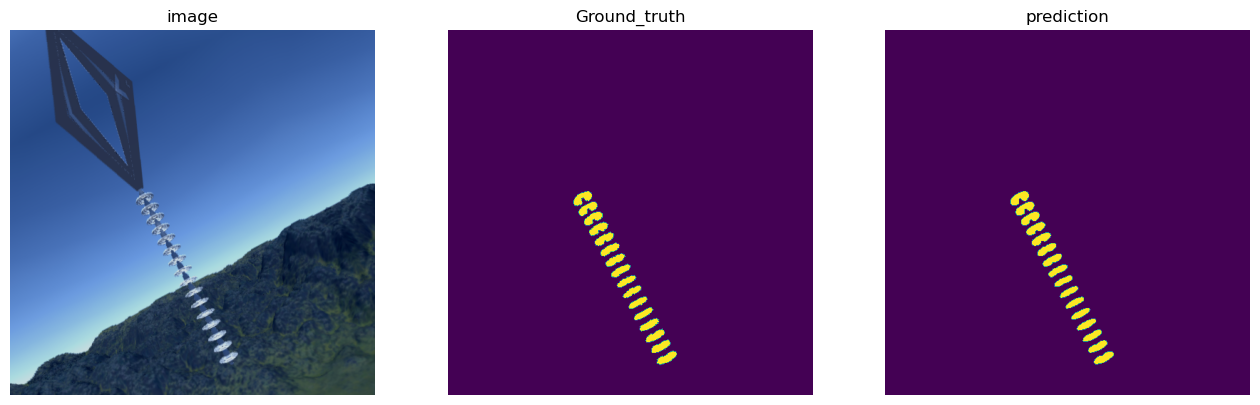

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg19_glass.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg19_glass.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_2436\3824017934.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

Linknet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()